In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
from src.leachSFtree import leachSFClusteringJoin, leachSFClusteringTreeJoin
from src.mst_prim import prim_mst, create_routes_dict
import src.util as util
import src.topology as topology
import networkx as nx
from src.nova_join import Operator, OperatorType, NovaSolver
from src.util import log_opt_label, coordinator_label, worker_label, centroid_label, ch_label, join_label
from src.cardinalities import create_cardinalities, create_adjacency_matrix, create_unique_n_tuples, \
    create_adjacency_matrix_from_pairs, generate_random_integer_dict
from src.util import evaluate_graph, evaluate_routes, plot_distributions_pdf
from src.topology import transition_uniform_to_exponential, create_topologies_from_dict
from src.baselines import sink_based_placement, source_based_placement, top_c
from src.eval_tools import *

### Topology Setup

In [2]:
seed = 10

worker_capacity = (1, 200)
source_capacity = (1, 50)
source_frac = 0.6
coord_cols = ["x", "y"]

X_dim = [-300, 300]
Y_dim = [-350, 300]
centers = 10
clustering = False

eval_matrix = {}

In [3]:
t_label = "atlas"
coord_dict = {t_label: topology.coords_ripe_atlas()}
device_number = coord_dict[t_label].shape[0]

In [4]:
prim_df, base_col, capacity_columns = \
create_topologies_from_dict(coord_dict, coord_cols, worker_capacity=worker_capacity,
                            source_capacity=source_capacity, source_frac=source_frac, with_clustering=clustering,
                            seed=seed)[t_label]

eval_columns = [base_col] + capacity_columns
opt_k = prim_df["cluster"].nunique()
num_sources = prim_df[prim_df["type"] == "SOURCE"].shape[0]
num_workers = prim_df[prim_df["type"] == "WORKER"].shape[0]
num_sinks = prim_df[prim_df["type"] == "SINK"].shape[0]
sink_indices = prim_df[prim_df["type"] == "SINK"].index.tolist()
coord_dict = prim_df[coord_cols].apply(list, axis=1).to_dict()

print(f"n={prim_df.shape[0]}, sinks={num_sinks}, workers={num_workers}, sources={num_sources}")
prim_df.head(10)

Creating df for atlas
Done
n=392, sinks=1, workers=157, sources=234


,x,y,label,cluster,latency,type,capacity_inf,capacity_0,capacity_1,capacity_2,capacity_3,capacity_4,capacity_5
0,202.799027,-47.855208,FR,0,0.000000,SINK,9999999,100,100,100,100,100,100
1,163.403715,-74.629814,IS,0,47.632658,SOURCE,9999999,38,32,28,25,22,19
2,181.481740,7.832968,AT,0,59.628850,SOURCE,9999999,2,2,2,2,3,3
3,231.431512,45.783553,FR,0,97.918521,SOURCE,9999999,32,25,20,17,14,11
4,140.587963,-156.846564,FR,0,125.496343,SOURCE,9999999,37,29,24,20,17,13
5,193.812130,50.217193,IE,0,98.483299,SOURCE,9999999,25,22,21,19,18,17
6,161.764590,-111.490255,SE,0,75.718190,SOURCE,9999999,12,26,34,41,48,53
7,219.140019,112.321914,UY,0,161.008504,SOURCE,9999999,10,10,9,9,9,8
8,165.689312,-43.594003,UY,0,37.353565,SOURCE,9999999,38,29,24,19,15,12
9,197.770963,-4.847822,US,0,43.300308,SOURCE,9999999,9,19,25,29,34,38


Total: Step 0 -> Sum: 20649, Mean: 52.81, Median: 34.00, Min: 1.00, Max: 197.00
Total: Step 1 -> Sum: 20647, Mean: 52.81, Median: 32.00, Min: 1.00, Max: 242.00
Total: Step 2 -> Sum: 20646, Mean: 52.80, Median: 31.00, Min: 1.00, Max: 276.00
Total: Step 3 -> Sum: 20642, Mean: 52.79, Median: 31.00, Min: 1.00, Max: 343.00
Total: Step 4 -> Sum: 20637, Mean: 52.78, Median: 29.00, Min: 0.00, Max: 403.00
Total: Step 5 -> Sum: 20651, Mean: 52.82, Median: 27.00, Min: 0.00, Max: 459.00
SOURCE: Step 0 -> Sum: 5604, Mean: 23.95, Median: 24.50, Min: 1.00, Max: 49.00
SOURCE: Step 1 -> Sum: 5600, Mean: 23.93, Median: 24.00, Min: 1.00, Max: 76.00
SOURCE: Step 2 -> Sum: 5597, Mean: 23.92, Median: 22.50, Min: 1.00, Max: 92.00
SOURCE: Step 3 -> Sum: 5599, Mean: 23.93, Median: 20.00, Min: 1.00, Max: 106.00
SOURCE: Step 4 -> Sum: 5598, Mean: 23.92, Median: 18.00, Min: 0.00, Max: 118.00
SOURCE: Step 5 -> Sum: 5599, Mean: 23.93, Median: 18.00, Min: 0.00, Max: 129.00
Total Mean: 52


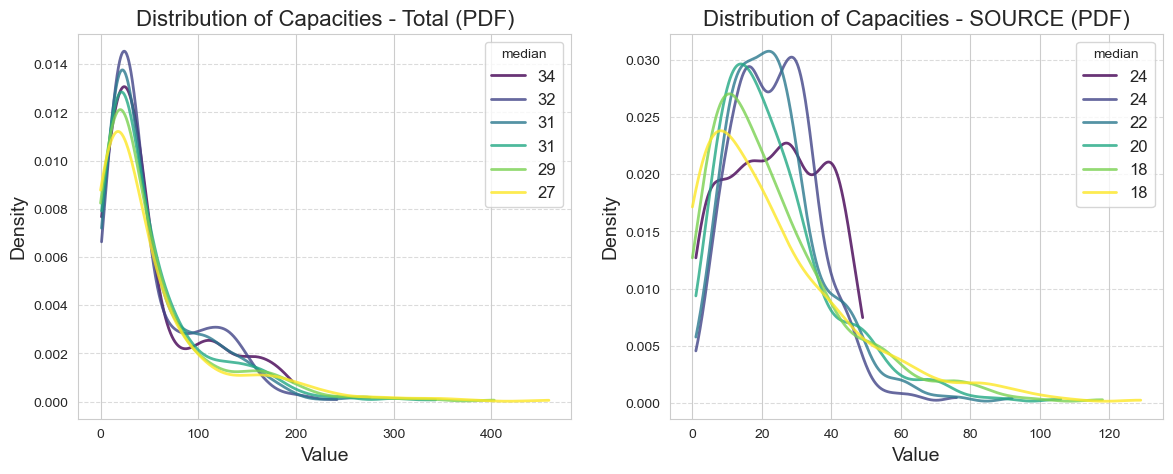

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Display the total distributions
distributions = []
medians = []
total_mean = []
sum_capacities = 0
for i, col in enumerate(capacity_columns):
    dist = prim_df[prim_df["type"] != "SINK"][col].to_numpy()
    distributions.append(dist)
    medians.append(np.median(dist))
    total_mean.append(np.mean(dist))
    sum_capacities += np.sum(dist)
    print(f"Total: Step {i} -> Sum: {np.sum(dist)}, Mean: {np.mean(dist):.2f}, Median: {np.median(dist):.2f}, Min: {np.min(dist):.2f}, Max: {np.max(dist):.2f}")
sum_capacities = sum_capacities // len(distributions)
# Plot the PDFs
dist_colors = plt.cm.viridis(np.linspace(0, 1, len(distributions)))
plot_distributions_pdf(axes[0], distributions, dist_colors)
axes[0].set_title('Distribution of Capacities - Total (PDF)', fontsize=16)

# Display the individual distributions
for cnt_idx, type in enumerate(["SOURCE"]):
    dist_type = []
    for i, col in enumerate(capacity_columns):
        dist = prim_df[prim_df["type"] == type][col].to_numpy()
        dist_type.append(dist)
        print(f"{type}: Step {i} -> Sum: {np.sum(dist)}, Mean: {np.mean(dist):.2f}, Median: {np.median(dist):.2f}, Min: {np.min(dist):.2f}, Max: {np.max(dist):.2f}")
    # Plot the PDFs
    dist_colors = plt.cm.viridis(np.linspace(0, 1, len(dist_type)))
    plot_distributions_pdf(axes[cnt_idx+1], dist_type, dist_colors)
    axes[cnt_idx+1].set_title(f'Distribution of Capacities - {type} (PDF)', fontsize=16)

total_mean = int(np.mean(total_mean))
print("Total Mean:", total_mean)

plt.savefig("plots/atlas/atlas_{0}_capacity_dist.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [6]:
colors, colors_hex, light_colors = util.get_color_list(opt_k)
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

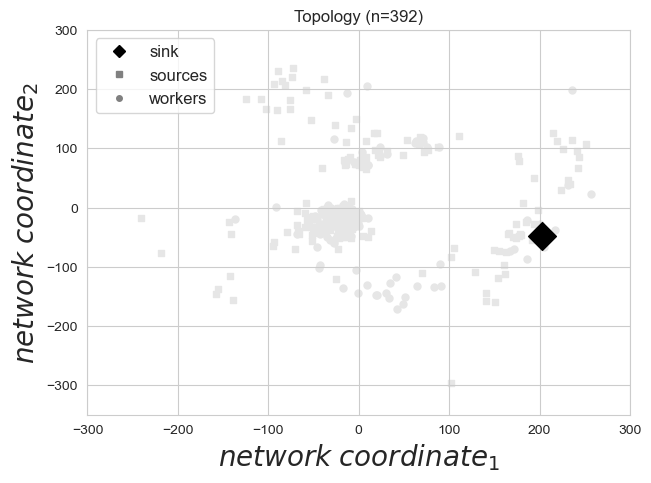

In [7]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, show_legend=True, show_coordinator=True)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

plt.savefig("plots/atlas/atlas_{0}_ncs.svg".format(str(device_number)), bbox_inches="tight")

plt.title(f"Topology (n={device_number})")

plt.show()

### Load Real RTTs

In [8]:
df_rtt_list = []
for i in range(0, 24):
    df_rtt = pd.read_csv(f"datasets/atlas/02072023/rtt_matrix/time-{i}.csv", sep=",")
    df_rtt.columns = range(0, len(df_rtt.columns))
    df_rtt_list.append(df_rtt)
df_rtt = df_rtt_list[0]

In [9]:
df_rtt.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630
0,0,20,58,37,38,62,394,392,175,31,22,38,37,242,186,41,279,26,24,51,702,346,86,62,16,159,263,58,298,186,48,21,32,66,41,63,24,53,69,22,21,54,42,298,76,15,196,93,95,222,47,20,9,46,23,31,69,69,64,47,87,46,68,60,14,13,38,9,104,41,184,205,100,352,62,19,471,47,58,93,28,364,22,85,549,28,74,225,25,186,219,30,52,12,485,11,193,209,21,275,20,368,27,63,321,409,310,8,73,82,215,43,30,41,658,216,145,179,12,9,303,31,183,71,38,61,30,374,37,30,65,45,25,98,204,438,196,43,29,319,277,423,321,23,346,306,38,34,73,190,36,636,24,159,763,22,56,80,24,48,22,172,58,32,337,175,27,177,280,35,24,8,14,81,39,62,25,43,42,31,248,26,39,451,9,32,32,8,30,21,22,262,332,374,161,323,34,33,80,521,15,20,174,678,193,228,133,725,201,199,301,291,32,399,56,52,35,334,36,168,25,38,20,450,199,31,524,23,495,436,27,458,854,471,16,229,157,23,294,21,29,89,398,19,80,41,119,22,50,62,31,20,53,69,44,338,460,12,58,357,16,312,41,74,519,16,32,22,85,22,43,26,179,86,238,30,156,323,581,25,56,90,36,26,96,347,354,380,71,19,49,343,374,380,351,381,396,366,343,21,83,59,1,289,52,175,357,372,291,80,368,386,7,165,173,8,335,22,16,466,173,239,15,61,421,27,564,34,32,32,47,46,304,54,12,15,73,14,14,398,240,21,54,81,18,48,22,291,283,295,338,62,190,82,88,22,29,624,82,28,22,7,69,250,61,51,22,69,26,21,62,27,40,40,153,99,25,53,30,24,191,316,38,32,427,193,440,40,63,77,153,20,24,267,69,312,303,20,548,585,638,569,307,335,23,14,15,538,186,225,61,190,171,688,425,79,141,269,354,280,26,8,46,86,253,32,23,22,64,298,39,37,173,32,15,89,43,298,48,204,9,31,308,35,162,314,410,359,54,360,279,568,138,191,15,35,21,15,28,18,333,30,182,319,300,26,39,177,48,574

### Create Join Matrix

In [10]:
# Create a list of labels for the index and columns
source_indices = list(prim_df[prim_df["type"] == "SOURCE"].index.values)
sink_capacity = len(source_indices) * 5
input_range = [1, 75]
output_range = [1, 200]
total_sum_sources = (np.mean(input_range) * num_sources)
prim_df.loc[prim_df[prim_df["type"] == "SINK"].index, capacity_columns] = sink_capacity + 0.4*sink_capacity
print(
    f"Sources={len(source_indices)}, Sum capacities={sum_capacities}; Sum load sources={total_sum_sources}; Sum load output={sink_capacity}")

source_cardinalities = generate_random_integer_dict(source_indices, total_sum_sources, input_range[0], input_range[1],
                                                    seed=seed)
join_pairs, unassigned = create_unique_n_tuples(source_indices, 2, shuffle=False)
join_matrix_df, join_matrix, required = create_adjacency_matrix_from_pairs(prim_df.shape[0], join_pairs, output_range,
                                                           output_sum=sink_capacity, seed=seed)
print(f"Required resources for sinks:{required}")
join_matrix_df.head(10)

Sources=234, Sum capacities=20645; Sum load sources=8892.0; Sum load output=1170
Generating n=234 random integers between 1 and 75, sum=8892.0
Generating n=117 random integers between 1 and 200, sum=1170
Required resources for sinks:1170


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

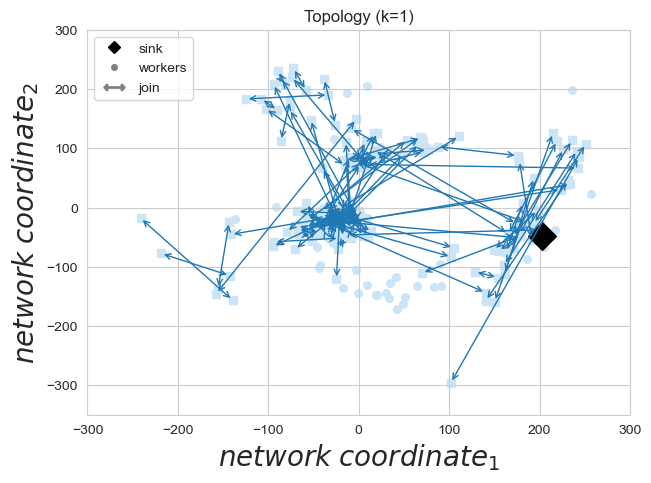

In [11]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

if clustering:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=True, plot_centroid=True)
else:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=False, plot_centroid=False)

for i, j in join_pairs:
    if join_matrix[i, j] > 0:
        point1 = prim_df.iloc[i][coord_cols].to_numpy()
        point2 = prim_df.iloc[j][coord_cols].to_numpy()
        cluster = prim_df.loc[i, "cluster"]
        # print(i, j, point1, point2)
        arrow = FancyArrowPatch(point1, point2, arrowstyle='<->', mutation_scale=10, color=colors[cluster], linewidth=1)
        ax1.add_patch(arrow)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# Create a custom handle for the double-ended arrow line
handles = [coordinator_label, worker_label, join_label]
ax1.legend(handles=handles, loc="upper left", bbox_to_anchor=(0, 1), prop={'size': 10})

plt.savefig(f"plots/atlas/atlas_{device_number}_ncs_grouped_{source_frac}.svg", bbox_inches="tight")

plt.show()

### Create Logical Plan

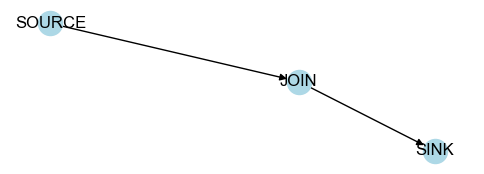

In [12]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 2))

# Create a graph
logical_plan = nx.DiGraph()

# Add nodes with labels as attributes
logical_plan.add_node(1, type=OperatorType.SOURCE)
logical_plan.add_node(2, type=OperatorType.JOIN)
logical_plan.add_node(3, type=OperatorType.SINK)

# Add edges between nodes
logical_plan.add_weighted_edges_from([(1, 2, 1), (2, 3, 1)])

# Draw the graph
pos = nx.nx_agraph.graphviz_layout(logical_plan, prog='neato')
nx.draw(logical_plan, pos, ax=ax1, with_labels=False, arrows=True, node_color='lightblue')

# Extract the labels from node attributes
labels = nx.get_node_attributes(logical_plan, 'type')

# Draw the labels on the graph
nx.draw_networkx_labels(logical_plan, pos, labels)

# Show the plot
plt.show()

## Perform Placement

### Nova

In [13]:
reduction_fac=0.4
cardinality_dict = {1: source_cardinalities, 2: (join_matrix, join_pairs)}

df_stats = None
nova_placements = {}

In [14]:
for capacity_col in eval_columns: #[eval_columns[2]]:
    print("Starting nova placement for", capacity_col)
    pdf = prim_df.copy()

    if capacity_col == base_col:
        nova = NovaSolver(pdf, logical_plan, cardinality_dict=cardinality_dict, coord_cols=coord_cols, reduction_fac=reduction_fac,
                      knn_neighbors=2, k_resources=prim_df[capacity_col].median()//2, capacity_col=capacity_col, use_weight=False, pre_knn=False)
    else:
        nova = NovaSolver(pdf, logical_plan, cardinality_dict=cardinality_dict, coord_cols=coord_cols, reduction_fac=reduction_fac,
                      knn_radius=155, k_resources=prim_df[capacity_col].median()//2, capacity_col=capacity_col, use_weight=False, pre_knn=False)

    df_nova_it, rep_plan_it, rel_positions_it, placement_it = nova.nova_full()

    nova_placements[capacity_col] = df_nova_it, rep_plan_it, rel_positions_it, placement_it
    df_stats_it = evaluate_graph(df_nova_it, rep_plan_it, df_rtt=df_rtt, placements=placement_it)
    eval_matrix["nova_" + capacity_col] = df_stats_it.copy()

Starting nova placement for capacity_inf
Initializing Nova for 392
Running Nova on capacity_inf
Resolving pinned operators
Resolving join operators
Preparing nodes and edges
Initializing coordinates
Computing relaxed positions for n=352 nodes
Relaxed positions: 352
Replicas for 1:234
Replication count for upstream operators to 1 -> 0
Replicas for 2:117
Distributing load: operator_id=393, opt=[182.41870526241613, -38.110445274154316], upstream_nodes=([np.int64(1), np.int64(2)])
Left=13, right=19, batches=12, batch_factor=0.4, batch_threshold=6.0, required=109, part_req=12 resource_limit=4999999.0, neighbor_size=2
Searching knn [182.41870526241613, -38.110445274154316] 391 2 2 0
Distributing finished: operator_id=393 (1, 2) to n=1, opt=[182.41870526241613, -38.110445274154316], upstream_nodes=[26], additional load=0.0
Distributing load: operator_id=394, opt=[191.32122940848268, -53.12086183359292], upstream_nodes=([np.int64(3), np.int64(4)])
Left=69, right=33, batches=8, batch_factor=0.4

In [15]:
for k, vals in nova_placements.items():
    df_nova, rep_plan_nova, rel_positions_nova, placement_nova = vals
    if df_nova[df_nova["free_capacity"] < 0].shape[0] > 0:
        print(f"Overloaded: {k}->{df_nova[df_nova['free_capacity'] < 0].shape[0]}")

In [16]:
plot_col = eval_columns[2]
df_nova, rep_plan_nova, rel_positions_nova, placement_nova = nova_placements[plot_col]

In [17]:
df_nova.head(10)

,x,y,type,unbalanced,weight,real_weight,total_capacity,free_capacity,level,parent
0,202.799027,-47.855208,SINK,0,0,0,1638,468.04,2,[]
1,163.403715,-74.629814,SOURCE,0,13,13,32,4.00,1,"[(250, 13), (0, 0.18)]"
2,181.481740,7.832968,SOURCE,0,19,19,2,2.00,0,"[(250, 19)]"
3,231.431512,45.783553,SOURCE,0,69,69,25,25.00,0,"[(324, 69)]"
4,140.587963,-156.846564,SOURCE,0,33,33,29,29.00,0,"[(324, 33)]"
5,193.812130,50.217193,SOURCE,0,32,32,22,22.00,0,"[(304, 32)]"
6,161.764590,-111.490255,SOURCE,0,11,11,26,26.00,0,"[(304, 11)]"
7,219.140019,112.321914,SOURCE,0,75,75,10,10.00,0,"[(302, 75)]"
8,165.689312,-43.594003,SOURCE,0,4,4,29,5.00,1,"[(302, 4), (0, 0.21)]"
9,197.770963,-4.847822,SOURCE,0,42,42,19,19.00,0,"[(299, 42)]"


In [18]:
eval_matrix.keys()

dict_keys(['nova_capacity_inf', 'nova_capacity_0', 'nova_capacity_1', 'nova_capacity_2', 'nova_capacity_3', 'nova_capacity_4', 'nova_capacity_5'])

#### Replication Plan

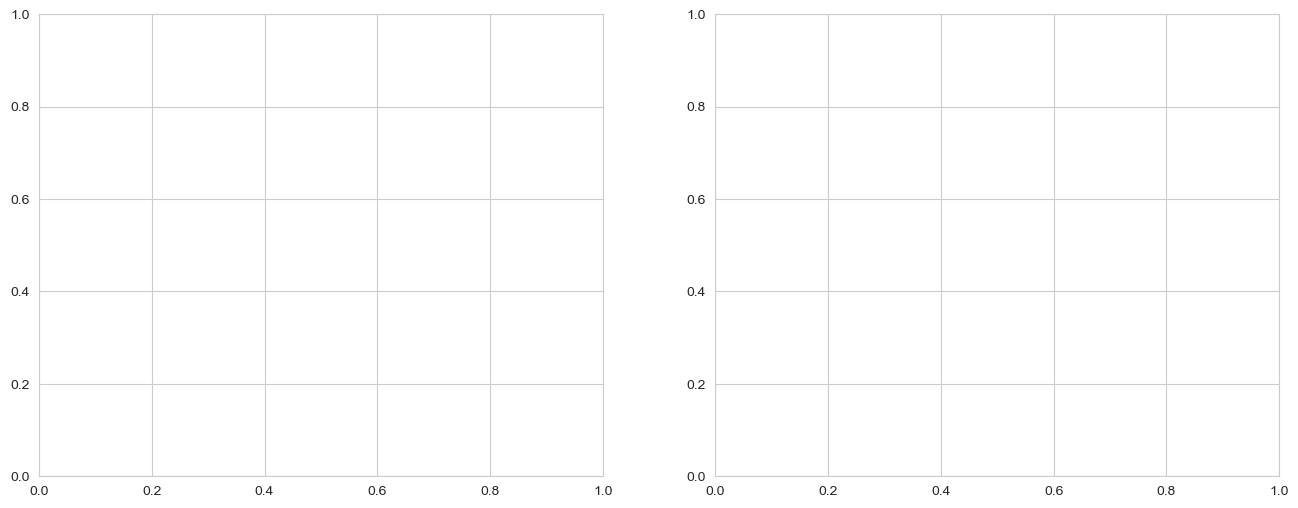

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for i_ax, edge_type in enumerate(["distance", "cardinality"]):
    if num_sources > 100:
        break
    # Draw the graph
    pos = nx.nx_agraph.graphviz_layout(rep_plan_nova, prog='neato')
    nx.draw(rep_plan_nova, pos, ax=axs[i_ax], with_labels=False, arrows=True, node_color='lightblue')

    # Extract and draw node labels
    node_labels = nx.get_node_attributes(rep_plan_nova, 'type')
    nx.draw_networkx_labels(rep_plan_nova, pos, ax=axs[i_ax], labels=node_labels)

    # Extract and draw edge labels based on edge attributes
    edge_labels = nx.get_edge_attributes(rep_plan_nova, edge_type)  # Replace 'attribute_name' with your edge attribute key
    nx.draw_networkx_edge_labels(rep_plan_nova, pos, ax=axs[i_ax], edge_labels=edge_labels)
    axs[i_ax].set_title("Replication Plan: " + edge_type)

# Show the plot
plt.show()

#### Placement

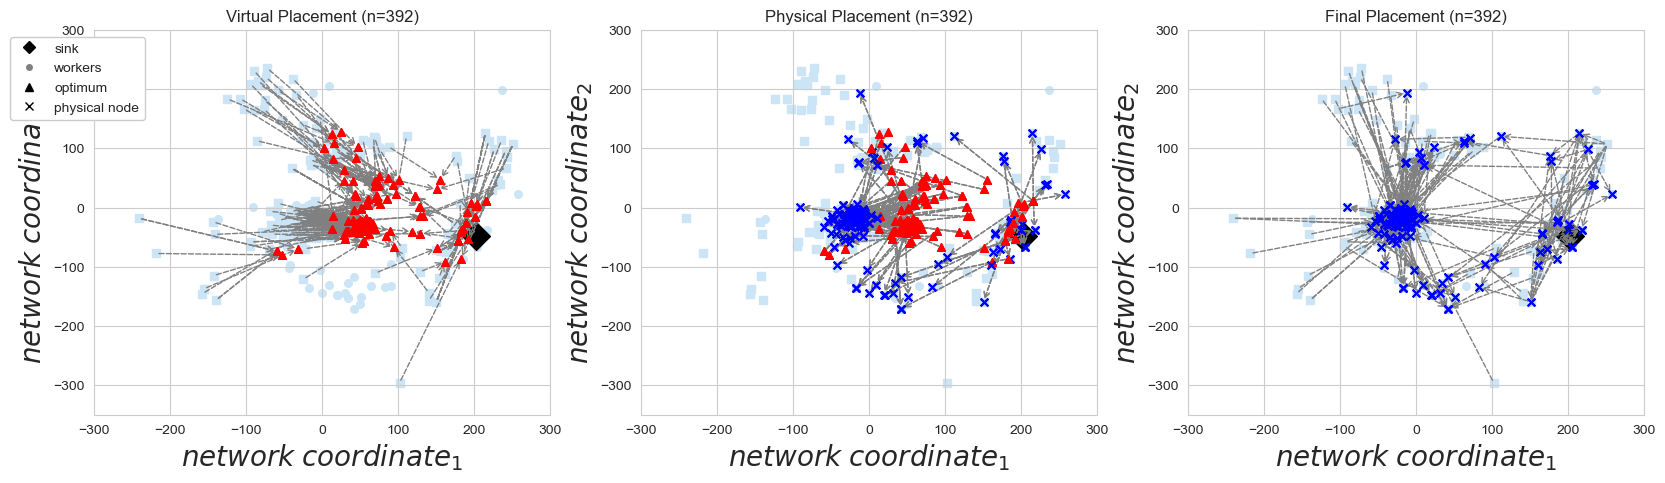

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
ax1, ax2, ax3 = axs
df_nova["cluster"] = 0

# resolve the placement
placement_coords = dict()
for key, val in placement_nova.items():
    placement_coords[key] = df_nova.loc[val, coord_cols].to_numpy()

ax1 = util.plot_topology(ax1, df_nova, colors=colors, title='Virtual Placement (n=' + str(device_number) + ")",
                         scale_fac=0.3, plot_voronoi=False, plot_centroid=False)
ax2 = util.plot_topology(ax2, df_nova, colors=colors, title='Physical Placement (n=' + str(device_number) + ")",
                         scale_fac=0.3, plot_voronoi=False, plot_centroid=False)
ax3 = util.plot_topology(ax3, df_nova, colors=colors, title='Final Placement (n=' + str(device_number) + ")",
                         scale_fac=0.3, plot_voronoi=False, plot_centroid=False)

for n1, n2 in rep_plan_nova.edges:
    if n2 not in df_nova.index:
        # plot the logical nodes
        ax1.scatter(rel_positions_nova[n2][0], rel_positions_nova[n2][1], s=30, color="red", marker="^", zorder=2)
        ax2.scatter(rel_positions_nova[n2][0], rel_positions_nova[n2][1], s=30, color="red", marker="^", zorder=2)

        # plot the physical nodes
        ax2.scatter(placement_coords[n2][0], placement_coords[n2][1], s=30, color="blue", marker="x", zorder=2)
        ax3.scatter(placement_coords[n2][0], placement_coords[n2][1], s=30, color="blue", marker="x", zorder=2)

    if n2 in df_nova.index:
        # arrow to the sink
        #arrow = FancyArrowPatch(placement_coords[n1], placement_coords[n2], arrowstyle='->', linestyle="-", mutation_scale=10, color="grey", linewidth=1)
        #ax3.add_patch(arrow)
        continue
    else:
        color = "grey"
        # physical nodes -> virtual nodes
        arrow = FancyArrowPatch(rel_positions_nova[n1], rel_positions_nova[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=1)
        ax1.add_patch(arrow)
        #arrow = FancyArrowPatch(rel_positions[n1], rel_positions[n2], arrowstyle='->', linestyle="--", mutation_scale=10, color=color, linewidth=1)
        #ax2.add_patch(arrow)
        # virtual node -> physical node
        arrow = FancyArrowPatch(rel_positions_nova[n2], placement_coords[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=1)
        ax2.add_patch(arrow)
        arrow = FancyArrowPatch(placement_coords[n1], placement_coords[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=1)
        ax3.add_patch(arrow)

    #arrow = FancyArrowPatch(placement[n1], placement[n2], arrowstyle='->', linestyle="--", mutation_scale=10, color="grey", linewidth=1)
    #ax3.add_patch(arrow)

handles = [coordinator_label, worker_label, log_opt_label, ch_label]
ax3.get_legend().remove()
ax2.get_legend().remove()
ax1.legend(handles=handles, loc="upper left", bbox_to_anchor=(-0.2, 1), prop={'size': 10}, framealpha=1)

for ax in axs:
    ax.set_xlim(X_dim)
    ax.set_ylim(Y_dim)

plt.savefig(f"plots/atlas/atlas_{device_number}_nova_complete_{source_frac}.svg", bbox_inches="tight")
plt.show()

## Baselines

### Experiment 1: Sink-based - Placement at the Sink


In [21]:
df_stats = sink_based_placement(coord_dict, sink_indices, join_pairs, source_cardinalities, df_rtt=df_rtt)
eval_matrix["sink-based"] = df_stats.copy()
df_stats.head()

,latency_distribution,latency_distribution_rtt,received_packets
0,0.0,0.0,8892.0
1,47.0,20.0,0.0
2,59.0,58.0,0.0
3,97.0,37.0,0.0
4,125.0,38.0,0.0


### Experiment 2: Source-based - Placement at the Sources

In [22]:
df_stats = source_based_placement(prim_df, coord_dict, join_matrix, join_pairs, source_cardinalities, df_rtt=df_rtt)
eval_matrix["source-based"] = df_stats.copy()

In [23]:
df_stats.head()

,latency_distribution,latency_distribution_rtt,received_packets
0,0.0,0.0,1170.0
1,143.0,99.0,0.0
2,59.0,58.0,13.0
3,97.0,37.0,33.0
4,319.0,78.0,0.0


### Experiment 3: Top-C - Placement at Highest Capacity Nodes

In [24]:
for capacity_col in eval_columns:
    df_stats = top_c(prim_df, coord_dict, join_matrix, join_pairs, source_cardinalities, capacity_col, df_rtt=df_rtt)
    eval_matrix["top-c_" + capacity_col] = df_stats.copy()
df_stats.head()

,latency_distribution,latency_distribution_rtt,received_packets
0,0.0,0.0,1170.0
1,407.0,1084.0,0.0
2,414.0,1204.0,0.0
3,469.0,1113.0,0.0
4,432.0,1211.0,0.0


### Experiment 3: Tree - Placement at intersections 

In [25]:
mst_coords = prim_df[coord_cols].apply(lambda row: tuple(row), axis=1).to_dict()
mst = prim_mst(mst_coords, root=0)
routes = create_routes_dict(mst)

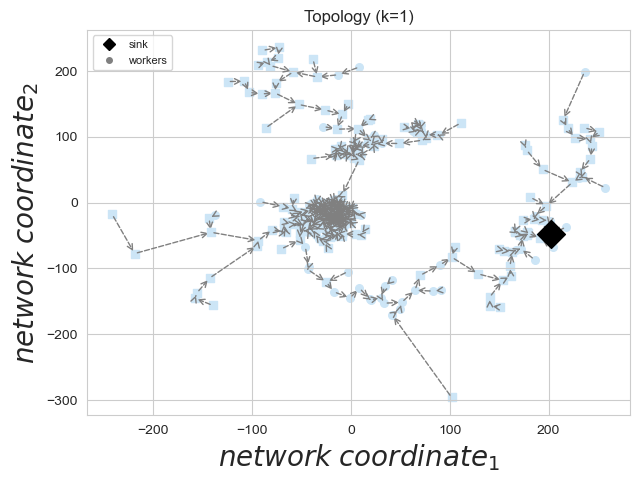

In [26]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
edge_color = "grey"

for node, parent in mst.items():
    point1 = prim_df.loc[node, coord_cols].to_numpy()
    point2 = prim_df.loc[parent, coord_cols].to_numpy()
    arrow = FancyArrowPatch(point1, point2, arrowstyle='->', linestyle="--", mutation_scale=10, color=edge_color,
                            linewidth=1)
    ax1.add_patch(arrow)

if clustering:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=True, plot_centroid=True)
else:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=False, plot_centroid=False)

ax1.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')

#ax1.set_xlim(X_dim)
#ax1.set_ylim(Y_dim)

plt.savefig("plots/atlas/atlas_{0}_mst.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [27]:
df_stats = evaluate_routes(prim_df, join_matrix, join_pairs, source_cardinalities, routes, df_rtt=df_rtt)
eval_matrix["tree"] = df_stats.copy()
df_stats.head()

,latency_distribution,latency_distribution_rtt,received_packets
0,0.000000,0.0,3380.0
1,62.694789,555.0,2569.0
2,81.609342,182.0,0.0
3,125.493210,423.0,306.0
4,152.210994,2042.0,21.0


### Clustering - Placement at intersecting Centroids

In [28]:
num_leach_clusters = max(4, int(0.1 * device_number))

df_cl_join = None

for capacity_col in eval_columns:
    df = prim_df.copy()
    df_cl_join, ch_indices, centers, u = leachSFClusteringJoin(df, capacity_col, num_leach_clusters)
    # evaluation
    routes = df_cl_join["route"].to_dict()
    df_stats = evaluate_routes(prim_df, join_matrix, join_pairs, source_cardinalities, routes, df_rtt=df_rtt)
    eval_matrix["cl-sf_" + capacity_col] = df_stats.copy()

In [29]:
df_cl_join.head()

,oindex,x,y,type,cluster,capacity_5,parent,route,level
0,0,202.799027,-47.855208,SINK,-1,1638,NaN,[],2
1,1,163.403715,-74.629814,SOURCE,12,19,0.0,[0],1
2,2,181.481740,7.832968,SOURCE,38,3,304.0,"[304, 0]",0
3,3,231.431512,45.783553,SOURCE,9,11,44.0,"[44, 0]",0
4,4,140.587963,-156.846564,SOURCE,2,13,73.0,"[73, 0]",0


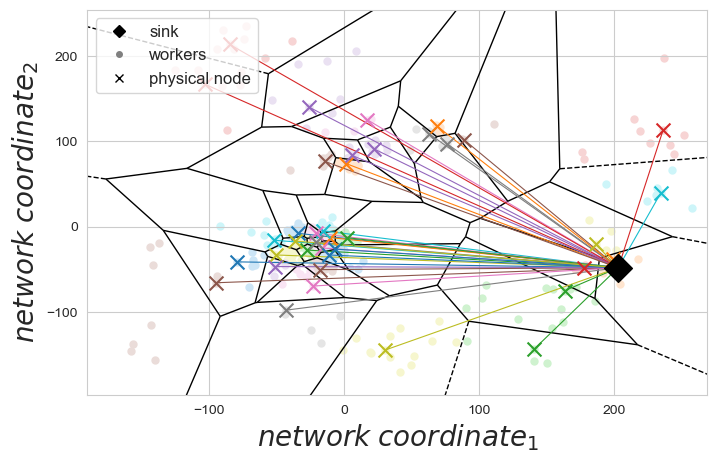

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

vor = False
if num_leach_clusters >= 4:
    vor = True
ax1 = util.plot(ax1, prim_df, df_cl_join, colors=leach_colors, plot_centroids=False, plot_lines=True, plot_voronoi=vor)

#ax1.set_xlim(X_dim)
#ax1.set_ylim(Y_dim)

plt.savefig("plots/atlas/atlas_{0}_clustering.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [31]:
df_stats.head()

,latency_distribution,latency_distribution_rtt,received_packets
0,0.000000,0.0,8347.0
1,47.632658,20.0,189.0
2,60.740092,96.0,0.0
3,99.605288,124.0,0.0
4,127.572393,683.0,0.0


### Clustering+Tree - Placement at Intersecting Trees

In [32]:
num_leach_clusters = max(4, int(0.1 * device_number))
df_clTree = None

for capacity_col in eval_columns:
    df = prim_df.copy()
    df_clTree, ch_indices, centers, u = leachSFClusteringTreeJoin(df, capacity_col, num_leach_clusters, coord_cols)

    # evaluation
    routes = df_clTree["route"].to_dict()
    df_stats = evaluate_routes(prim_df, join_matrix, join_pairs, source_cardinalities, routes, df_rtt=df_rtt)
    eval_matrix["cl-tree-sf_" + capacity_col] = df_stats.copy()

In [33]:
df_clTree.head()

,oindex,x,y,type,cluster,capacity_5,parent,route,level
0,0,202.799027,-47.855208,SINK,-1,1638,NaN,[],21
1,1,163.403715,-74.629814,SOURCE,23,19,14.0,"[14, 0]",19
2,2,181.481740,7.832968,SOURCE,19,3,200.0,"[200, 0]",19
3,3,231.431512,45.783553,SOURCE,13,11,44.0,"[44, 200, 0]",18
4,4,140.587963,-156.846564,SOURCE,33,13,73.0,"[73, 136, 1, 14, 0]",16


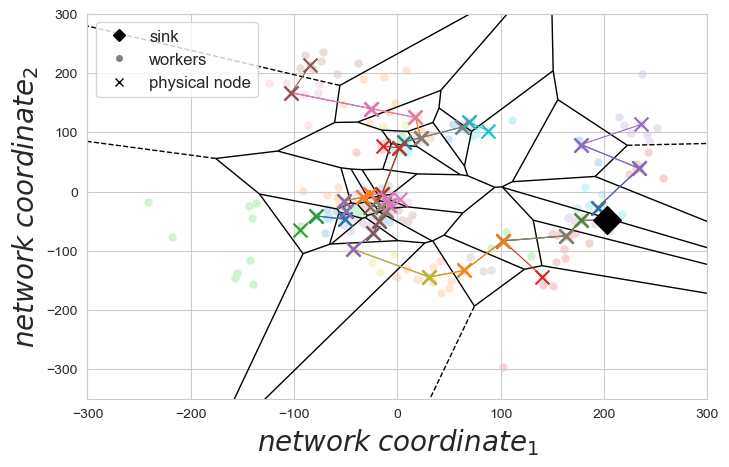

In [34]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

vor = False
if num_leach_clusters >= 4:
    vor = True
ax1 = util.plot(ax1, prim_df, df_clTree, colors=leach_colors, plot_centroids=False, plot_lines=True, plot_voronoi=vor)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

plt.savefig("plots/atlas/atlas_{0}_clustering_tree.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [35]:
df_stats.head()

,latency_distribution,latency_distribution_rtt,received_packets
0,0.000000,0.0,3510.0
1,54.842900,413.0,2589.0
2,59.662806,51.0,0.0
3,107.397317,139.0,0.0
4,201.464212,1360.0,0.0


## Evaluation

In [36]:
homogeneous = ['sink-based', 'source-based', 'tree']
heterogeneous = ["cl-sf", "cl-tree-sf", "top-c"] + ["nova"]

In [37]:
eval_matrix.keys()

dict_keys(['nova_capacity_inf', 'nova_capacity_0', 'nova_capacity_1', 'nova_capacity_2', 'nova_capacity_3', 'nova_capacity_4', 'nova_capacity_5', 'sink-based', 'source-based', 'top-c_capacity_inf', 'top-c_capacity_0', 'top-c_capacity_1', 'top-c_capacity_2', 'top-c_capacity_3', 'top-c_capacity_4', 'top-c_capacity_5', 'tree', 'cl-sf_capacity_inf', 'cl-sf_capacity_0', 'cl-sf_capacity_1', 'cl-sf_capacity_2', 'cl-sf_capacity_3', 'cl-sf_capacity_4', 'cl-sf_capacity_5', 'cl-tree-sf_capacity_inf', 'cl-tree-sf_capacity_0', 'cl-tree-sf_capacity_1', 'cl-tree-sf_capacity_2', 'cl-tree-sf_capacity_3', 'cl-tree-sf_capacity_4', 'cl-tree-sf_capacity_5'])

### Latency

In [38]:
approach_order = get_approaches()
eval_colors = get_eval_colors_dict()
markers = get_markers_dict()
styles = get_styles_dict()

sink-based sink-based
source-based source-based
top-c top-c_capacity_inf
tree tree
cl-sf cl-sf_capacity_inf
cl-tree-sf cl-tree-sf_capacity_inf
nova nova_capacity_inf
nova (p) nova_capacity_5


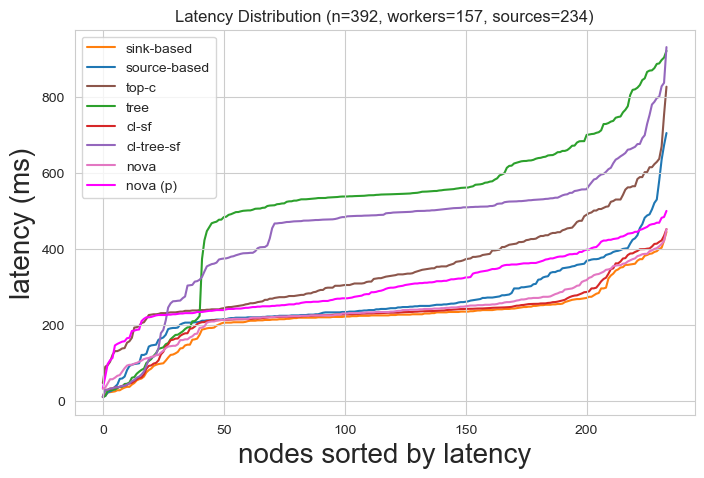

mean_dict = {'sink-based': np.float64(220.53), 'source-based': np.float64(261.72), 'top-c': np.float64(345.6), 'tree': np.float64(512.43), 'cl-sf': np.float64(231.15), 'cl-tree-sf': np.float64(450.65), 'nova': np.float64(237.68), 'nova (p)': np.float64(302.33)}
quant_dict = {'sink-based': np.float64(327.6), 'source-based': np.float64(387.4), 'top-c': np.float64(520.4), 'tree': np.float64(733.91), 'cl-sf': np.float64(343.17), 'cl-tree-sf': np.float64(612.39), 'nova': np.float64(347.4), 'nova (p)': np.float64(424.0)}
mean_dict_real = {'sink-based': np.float64(146.39), 'source-based': np.float64(262.91), 'top-c': np.float64(330.26), 'tree': np.float64(11690.35), 'cl-sf': np.float64(335.18), 'cl-tree-sf': np.float64(1916.32), 'nova': np.float64(259.74), 'nova (p)': np.float64(379.21)}
quant_dict_real =  {'sink-based': np.float64(386.6), 'source-based': np.float64(662.9), 'top-c': np.float64(708.7), 'tree': np.float64(19178.3), 'cl-sf': np.float64(782.1), 'cl-tree-sf': np.float64(3056.2), '

In [39]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}
quant_dict_real = {}
mean_dict_real = {}
eval_labels = []

for label in approach_order:
    if label in heterogeneous:
        eval_labels.append((label, label + "_" + eval_columns[0]))
        if label.startswith("nova"):
            eval_labels.append((label + " (p)", label + "_" + eval_columns[-1]))
    else:
        eval_labels.append((label, label))

#plot baselines
for label, eval_col in eval_labels:
    print(label, eval_col)
    eval_df = eval_matrix[eval_col]["latency_distribution"][eval_matrix[eval_col]["latency_distribution"] > 0]
    sv = eval_df.sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[label] = round(eval_df.quantile(0.9), 2)
    mean_dict[label] = round(eval_df.mean(), 2)

    if "latency_distribution_rtt" in eval_matrix[eval_col].columns:
        eval_df = eval_matrix[eval_col]["latency_distribution_rtt"][eval_matrix[eval_col]["latency_distribution_rtt"] > 0]
        quant_dict_real[label] = round(eval_df.quantile(0.9), 2)
        mean_dict_real[label] = round(eval_df.mean(), 2)

    if label == "nova":
        zorder = 100
    else:
        zorder = 0
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=label, color=eval_colors[label], zorder=zorder)

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/atlas/atlas_{0}_eval_latency.svg".format(str(device_number)), bbox_inches="tight")

ax1.set_title(f'Latency Distribution (n={device_number}, workers={num_workers}, sources={num_sources})')
plt.show()
print("mean_dict =", mean_dict)
print("quant_dict =", quant_dict)
print("mean_dict_real =", mean_dict_real)
print("quant_dict_real = ", quant_dict_real)

### Heterogeneity

In [40]:
eval_matrix_load = eval_matrix.copy()
eval_matrix_load.keys()

dict_keys(['nova_capacity_inf', 'nova_capacity_0', 'nova_capacity_1', 'nova_capacity_2', 'nova_capacity_3', 'nova_capacity_4', 'nova_capacity_5', 'sink-based', 'source-based', 'top-c_capacity_inf', 'top-c_capacity_0', 'top-c_capacity_1', 'top-c_capacity_2', 'top-c_capacity_3', 'top-c_capacity_4', 'top-c_capacity_5', 'tree', 'cl-sf_capacity_inf', 'cl-sf_capacity_0', 'cl-sf_capacity_1', 'cl-sf_capacity_2', 'cl-sf_capacity_3', 'cl-sf_capacity_4', 'cl-sf_capacity_5', 'cl-tree-sf_capacity_inf', 'cl-tree-sf_capacity_0', 'cl-tree-sf_capacity_1', 'cl-tree-sf_capacity_2', 'cl-tree-sf_capacity_3', 'cl-tree-sf_capacity_4', 'cl-tree-sf_capacity_5'])

In [41]:
load_dict = {}
load_norm_dict = {}
nn_dict = {}

for k in approach_order:
    slot_list = []
    slot_list_norm = []
    nn_list = []
    for colname in capacity_columns:
        if k in homogeneous:
            df = eval_matrix_load[k]
        else:
            df = eval_matrix_load[k + "_" + colname]
        df["av_capacity"] = prim_df[colname] - df["received_packets"]
        agg_nodes = df["received_packets"][df["received_packets"] > 0].count()
        tmp_df_sl = df[df["av_capacity"] < 0]
        tmp_df_nn = df[df["av_capacity"] >= 0]
        slot_list.append(tmp_df_sl["av_capacity"].count())
        slot_list_norm.append(int((tmp_df_sl["av_capacity"].count() / agg_nodes) * 100))
        nn_list.append(tmp_df_nn["av_capacity"].count())
    load_dict[k] = slot_list
    load_norm_dict[k] = slot_list_norm
    nn_dict[k] = nn_list

In [42]:
load_dict.keys()

dict_keys(['sink-based', 'source-based', 'top-c', 'tree', 'cl-sf', 'cl-tree-sf', 'nova'])

In [43]:
agg_arr1 = []
for fam in load_dict.keys():
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])
    print(load_norm_dict[fam])

Fam:  sink-based
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
[100, 100, 100, 100, 100, 100]
Fam:  source-based
[np.int64(64), np.int64(65), np.int64(69), np.int64(71), np.int64(77), np.int64(76)]
[54, 55, 58, 60, 65, 64]
Fam:  top-c
[np.int64(13), np.int64(14), np.int64(15), np.int64(13), np.int64(10), np.int64(6)]
[14, 15, 16, 16, 13, 8]
Fam:  tree
[np.int64(256), np.int64(255), np.int64(254), np.int64(255), np.int64(253), np.int64(253)]
[88, 88, 87, 88, 87, 87]
Fam:  cl-sf
[np.int64(38), np.int64(34), np.int64(37), np.int64(37), np.int64(37), np.int64(40)]
[97, 91, 92, 92, 94, 100]
Fam:  cl-tree-sf
[np.int64(38), np.int64(39), np.int64(39), np.int64(38), np.int64(40), np.int64(40)]
[97, 97, 97, 97, 100, 100]
Fam:  nova
[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
[0, 0, 0, 0, 0, 0]


sink-based -- 2 (1.0, 0.4980392156862745, 0.054901960784313725) : [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
source-based - 1 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765) : [np.int64(64), np.int64(65), np.int64(69), np.int64(71), np.int64(77), np.int64(76)]
top-c -. 3 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354) : [np.int64(13), np.int64(14), np.int64(15), np.int64(13), np.int64(10), np.int64(6)]
tree : o (0.17254901960784313, 0.6274509803921569, 0.17254901960784313) : [np.int64(256), np.int64(255), np.int64(254), np.int64(255), np.int64(253), np.int64(253)]
cl-sf - < (0.8392156862745098, 0.15294117647058825, 0.1568627450980392) : [np.int64(38), np.int64(34), np.int64(37), np.int64(37), np.int64(37), np.int64(40)]
cl-tree-sf -- > (0.5803921568627451, 0.403921568627451, 0.7411764705882353) : [np.int64(38), np.int64(39), np.int64(39), np.int64(38), np.int64(40), np.int64(40)]
nova (0, (3, 1, 1, 1)) * (0.89019607843137

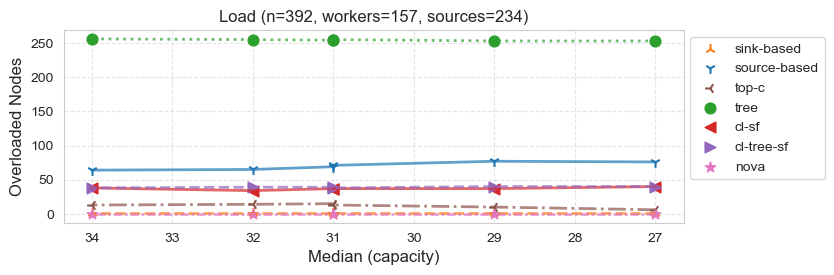

In [44]:
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 2.5))

medians_plot = medians

for fam in load_dict.keys():
    vals = load_dict[fam]
    print(fam, styles[fam], markers[fam], eval_colors[fam], ":", vals)

    # Ensure data is sorted for a proper line plot
    sorted_indices = np.argsort(medians_plot)
    medians_sorted = np.array(medians_plot)[sorted_indices]
    vals_sorted = np.array(vals)[sorted_indices]

    # Plot the scatter points
    ax.scatter(medians_sorted, vals_sorted, marker=markers[fam], color=eval_colors[fam], label=fam, s=60)
    # Plot the line with the desired linestyle
    ax.plot(medians_sorted, vals_sorted, linestyle=styles[fam], color=eval_colors[fam], linewidth=2, alpha=0.7)

ax.invert_xaxis()
ax.set_xlabel("Median (capacity)", fontsize=12)
ax.set_ylabel("Overloaded Nodes", fontsize=12)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(visible=True, linestyle='--', alpha=0.5)

plt.savefig(f"plots/atlas/atlas_{device_number}_eval_load_abs_{source_frac}.svg", bbox_inches="tight")
ax.set_title(f"Load (n={device_number}, workers={num_workers}, sources={num_sources})")
plt.show()

sink-based -- 2 (1.0, 0.4980392156862745, 0.054901960784313725) : [100, 100, 100, 100, 100, 100]
source-based - 1 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765) : [54, 55, 58, 60, 65, 64]
top-c -. 3 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354) : [14, 15, 16, 16, 13, 8]
tree : o (0.17254901960784313, 0.6274509803921569, 0.17254901960784313) : [88, 88, 87, 88, 87, 87]
cl-sf - < (0.8392156862745098, 0.15294117647058825, 0.1568627450980392) : [97, 91, 92, 92, 94, 100]
cl-tree-sf -- > (0.5803921568627451, 0.403921568627451, 0.7411764705882353) : [97, 97, 97, 97, 100, 100]
nova (0, (3, 1, 1, 1)) * (0.8901960784313725, 0.4666666666666667, 0.7607843137254902) : [0, 0, 0, 0, 0, 0]


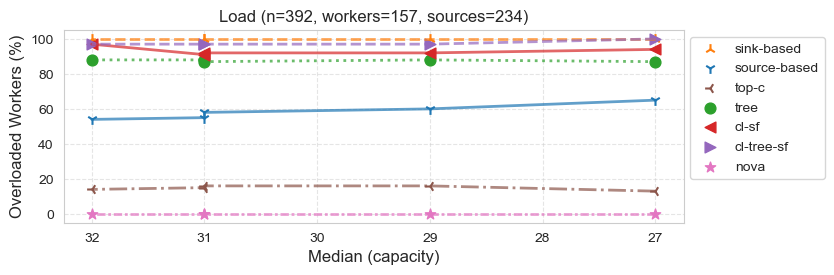

In [50]:
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 2.5))

medians_plot = medians[1:]

for fam in load_norm_dict.keys():
    vals = load_norm_dict[fam]
    print(fam, styles[fam], markers[fam], eval_colors[fam], ":", vals)

    # Ensure data is sorted for a proper line plot
    sorted_indices = np.argsort(medians_plot)
    medians_sorted = np.array(medians_plot)[sorted_indices]
    vals_sorted = np.array(vals)[sorted_indices]

    # Plot the scatter points
    ax.scatter(medians_sorted, vals_sorted, marker=markers[fam], color=eval_colors[fam], label=fam, s=60)
    # Plot the line with the desired linestyle
    ax.plot(medians_sorted, vals_sorted, linestyle=styles[fam], color=eval_colors[fam], linewidth=2, alpha=0.7)

ax.invert_xaxis()
ax.set_xlabel("Median (capacity)", fontsize=12)
ax.set_ylabel("Overloaded Workers (%)", fontsize=12)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(visible=True, linestyle='--', alpha=0.5)

plt.savefig(f"plots/atlas/atlas_{device_number}_eval_load_perc_{source_frac}.svg", bbox_inches="tight")

ax.set_title(f"Load (n={device_number}, workers={num_workers}, sources={num_sources})")
plt.show()

In [48]:
mean_dict

{'sink-based': np.float64(220.53),
 'source-based': np.float64(261.72),
 'top-c': np.float64(345.6),
 'tree': np.float64(512.43),
 'cl-sf': np.float64(231.15),
 'cl-tree-sf': np.float64(450.65),
 'nova': np.float64(237.68),
 'nova (p)': np.float64(302.33)}

In [49]:
quant_dict

{'sink-based': np.float64(327.6),
 'source-based': np.float64(387.4),
 'top-c': np.float64(520.4),
 'tree': np.float64(733.91),
 'cl-sf': np.float64(343.17),
 'cl-tree-sf': np.float64(612.39),
 'nova': np.float64(347.4),
 'nova (p)': np.float64(424.0)}